# MARIS seawater data 

> A Spatial analysis treatment

Refs:  
- https://darribas.org/gds_course/content/bG/lab_G.html
- https://geographicdata.science/book/notebooks/00_toc.html
- https://geodacenter.github.io/documentation.html

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd

from shapely.geometry import Point
from pysal.explore import esda
from pysal.lib import weights

import matplotlib.pyplot as plt
import seaborn
import contextily

from splot import esda as esdaplot

## Utilities

In [ ]:
def quick_plot(db, column='activity', alpha=0.5, ms=3):
    f, ax = plt.subplots(1, figsize=(9, 9))
    db.plot(
        column=column,
        cmap="viridis",
        scheme="quantiles",
        k=5,
        edgecolor="white",
        linewidth=0.0,
        alpha=alpha,
        legend=True,
        legend_kwds={"loc": 2},
        ax=ax,
        markersize=ms
    )
    contextily.add_basemap(
        ax,
        crs=db.crs,
        source=contextily.providers.CartoDB.Positron
        
    )
    ax.set_axis_off()

## Data loading

In [ ]:
fname = Path.home() / 'pro/data/maris/maris-seawater-lamer-2023-07-25.csv'
df = pd.read_csv(fname); df.shape

(29419, 13)

In [ ]:
# Filtering out North Atlantic Ocean
#df = df[df['area_name'] != 'North Atlantic Ocean']

In [ ]:
df['begperiod'] = pd.to_datetime(df['begperiod'])

In [ ]:
df.head()

,smp_id,lat,lon,area_name,area_id,depth,profile_id,begperiod,nusymbol,unit,activity,uncertainty,ref_id
0,10829,56.783333,-8.000000,North Atlantic Ocean,1912,40.0,NaN,1984-06-27,137Cs,Bq/m3,99.84,1.40,84
1,10045,57.000000,-20.000000,North Atlantic Ocean,1912,3.0,NaN,1981-03-15,137Cs,Bq/m3,5.74,0.66,84
2,5811,59.000000,-6.000000,North Atlantic Ocean,1912,79.0,NaN,1973-07-22,137Cs,Bq/m3,22.57,NaN,84
3,3324,58.590000,-3.791667,North Atlantic Ocean,1912,0.0,NaN,1967-11-08,137Cs,Bq/m3,359.64,NaN,84
4,3747,58.583333,-3.766667,North Atlantic Ocean,1912,0.0,NaN,1966-05-25,137Cs,Bq/m3,92.13,NaN,84


## Preview

In [ ]:
geometry = [Point(lon, lat) for lon, lat in zip(df['lon'], df['lat'])]

db = (
    (gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326"))
    .to_crs(epsg=3857)[
    ["area_name", "begperiod", "activity", "geometry"]
    ]
    .dropna()
    )
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 28951 entries, 0 to 29418
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   area_name  28951 non-null  object        
 1   begperiod  28951 non-null  datetime64[ns]
 2   activity   28951 non-null  float64       
 3   geometry   28951 non-null  geometry      
dtypes: datetime64[ns](1), float64(1), geometry(1), object(1)
memory usage: 1.1+ MB


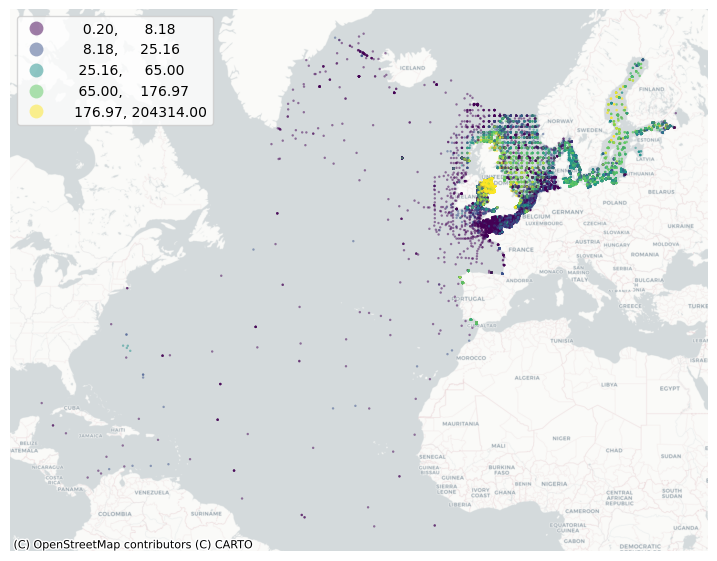

In [ ]:
# Plotting activity
f, ax = plt.subplots(1, figsize=(9, 9))
db.plot(
    column="activity",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.5,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax,
    markersize=3
)
contextily.add_basemap(
    ax,
    crs=db.crs,
    source=contextily.providers.CartoDB.Positron
    
)
ax.set_axis_off()

## Global spatial autocorrelation

In [ ]:
# Generate W from the GeoDataFrame
w = weights.KNN.from_dataframe(db, k=8)
# Row-standardization
w.transform = "R"

/Users/franckalbinet/mambaforge/envs/marisco/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 320 disconnected components.
  warnings.warn(message)


In [ ]:
db["activity_lag"] = weights.spatial_lag.lag_spatial(
    w, db["activity"]
)

In [ ]:
db.head()

,area_name,begperiod,activity,geometry,activity_lag
0,North Atlantic Ocean,1984-06-27,99.84,POINT (-890555.926 7715962.221),263.261250
1,North Atlantic Ocean,1981-03-15,5.74,POINT (-2226389.816 7760118.673),14.517500
2,North Atlantic Ocean,1973-07-22,22.57,POINT (-667916.945 8180386.886),59.955875
3,North Atlantic Ocean,1967-11-08,359.64,POINT (-422086.403 8092292.939),381.531250
4,North Atlantic Ocean,1966-05-25,92.13,POINT (-419303.415 8090869.075),246.466250


### Smoothing nature of spatial lag

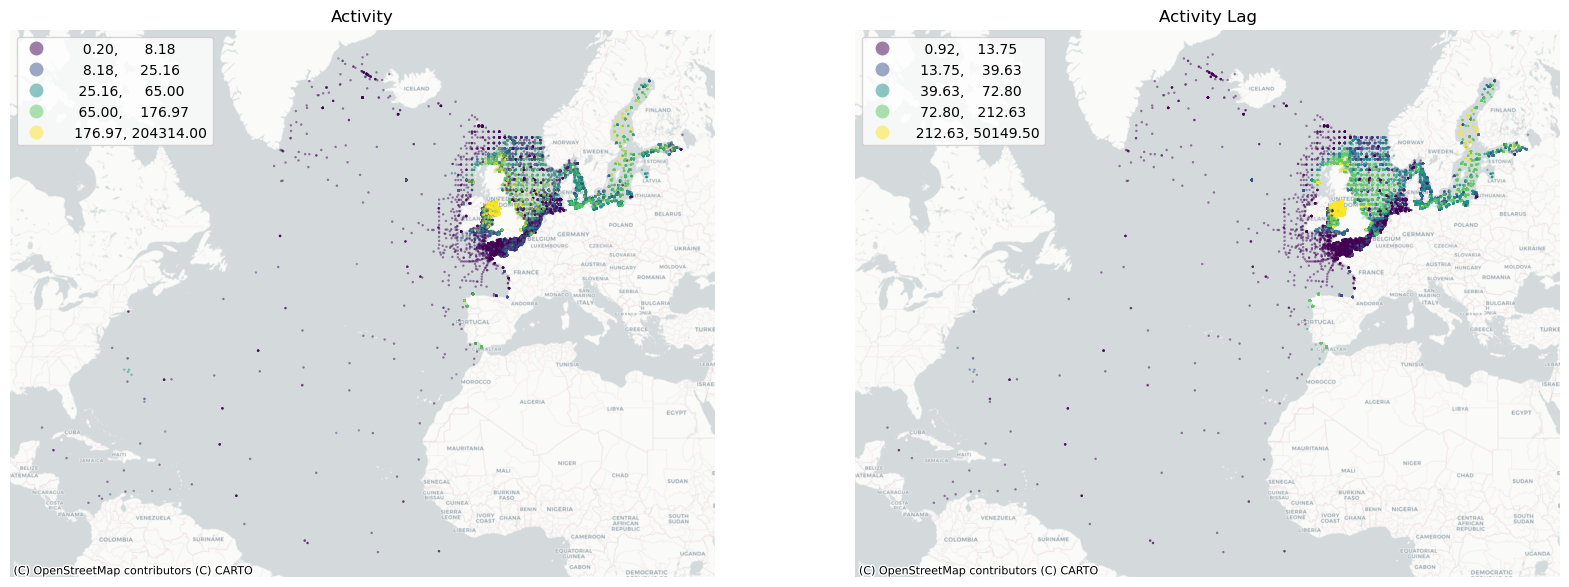

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(20, 10))
ax1, ax2 = axs

db.plot(
    column="activity",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.5,
    legend=True,
    markersize=3,
    ax=ax1,
)
ax1.set_axis_off()
ax1.set_title("Activity")
contextily.add_basemap(
    ax1,
    crs=db.crs,
    source=contextily.providers.CartoDB.Positron,
)

db.plot(
    column="activity_lag",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.5,
    legend=True,
    markersize=3,
    ax=ax2,
)
ax2.set_axis_off()
ax2.set_title("Activity Lag")
contextily.add_basemap(
    ax2,
    crs=db.crs,
    source=contextily.providers.CartoDB.Positron,
)

### Moran Plot and Moran’s I

In [ ]:
db['activity_log'] = np.log10(db.activity)

In [ ]:
db["activity_std"] = db["activity_log"] - db["activity_log"].mean()
db["activity_lag_std"] = weights.lag_spatial(
    w, db["activity_std"]
)

In [ ]:
db.head()

,area_name,begperiod,activity,geometry,activity_lag,activity_log,activity_std,activity_lag_std
0,North Atlantic Ocean,1984-06-27,99.84,POINT (-890555.926 7715962.221),263.261250,1.999305,0.324275,0.610451
1,North Atlantic Ocean,1981-03-15,5.74,POINT (-2226389.816 7760118.673),14.517500,0.758912,-0.916117,-0.682764
2,North Atlantic Ocean,1973-07-22,22.57,POINT (-667916.945 8180386.886),59.955875,1.353532,-0.321498,-0.101828
3,North Atlantic Ocean,1967-11-08,359.64,POINT (-422086.403 8092292.939),381.531250,2.555868,0.880839,0.772301
4,North Atlantic Ocean,1966-05-25,92.13,POINT (-419303.415 8090869.075),246.466250,1.964401,0.289372,0.636233


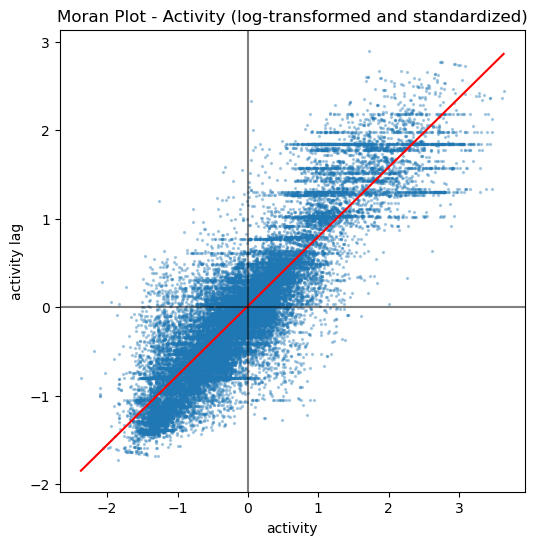

In [ ]:
f, ax = plt.subplots(1, figsize=(6, 6))
seaborn.regplot(
    x="activity_std",
    y="activity_lag_std",
    ci=None,
    data=db,
    line_kws={"color": "r", "lw":1.5},
    scatter_kws={"alpha": 0.3, "s": 2}
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_xlabel("activity")
ax.set_ylabel("activity lag")
ax.set_title("Moran Plot - Activity (log-transformed and standardized)");

The plot displays a positive relationship between both variables. This is indicates the presence of positive spatial autocorrelation: similar values tend to be located close to each other. This means that the overall trend is for high values to be close to other high values, and for low values to be surrounded by other low values. This, however, does not mean that this is the only case in the dataset: there can of course be particular situations where high values are surrounded by low ones, and vice versa. But it means that, if we had to summarize the main pattern of the data in terms of how clustered similar values are, the best way would be to say they are positively correlated and, hence, clustered over space. 

In [ ]:
w.transform = "R"
moran = esda.moran.Moran(db["activity_log"], w)

In [ ]:
moran.I

0.7837792904070477

In [ ]:
moran.p_sim

0.001

#### By IHO region

In [ ]:
db.area_name.unique()

array(['North Atlantic Ocean', 'North Sea', 'Celtic Sea',
       "Irish Sea and St. George's Channel", 'Bay of Biscay', 'Kattegat',
       'Skagerrak', 'English Channel', 'Baltic Sea', 'Gulf of Bothnia',
       'Gulf of Finland', 'Gulf of Riga', 'Bristol Channel',
       'Caribbean Sea', 'Gulf of Mexico'], dtype=object)

In [ ]:
morans = {'area_name': [], 'moran.I': [], 'moran.p_sim': [], 'n': []}
knn = 8
for name, df in db.groupby('area_name'):
    if len(df) > 1:
        w_iho = weights.KNN.from_dataframe(df, k=knn, silence_warnings=True)
        w_iho.transform = "R"
        moran = esda.moran.Moran(df["activity_log"], w_iho)
        morans['area_name'].append(name)
        morans['moran.I'].append(moran.I)
        morans['moran.p_sim'].append(moran.p_sim)
        morans['n'].append(len(df))
    else:
        print(f'area_name: {name} # of measurements < # of knn: {knn}')
        
df_morans = pd.DataFrame(morans)
df_morans.sort_values(by=['moran.I'], ascending=False)

area_name: Gulf of Mexico # of measurements < # of knn: 8


,area_name,moran.I,moran.p_sim,n
11,North Atlantic Ocean,0.749265,0.001,2698
4,Celtic Sea,0.740077,0.001,911
9,Irish Sea and St. George's Channel,0.697798,0.001,6392
12,North Sea,0.612515,0.001,6845
6,Gulf of Bothnia,0.571308,0.001,463
0,Baltic Sea,0.468396,0.001,3863
13,Skagerrak,0.456107,0.001,411
5,English Channel,0.423762,0.001,3826
7,Gulf of Finland,0.331811,0.001,837
2,Bristol Channel,0.326284,0.001,380


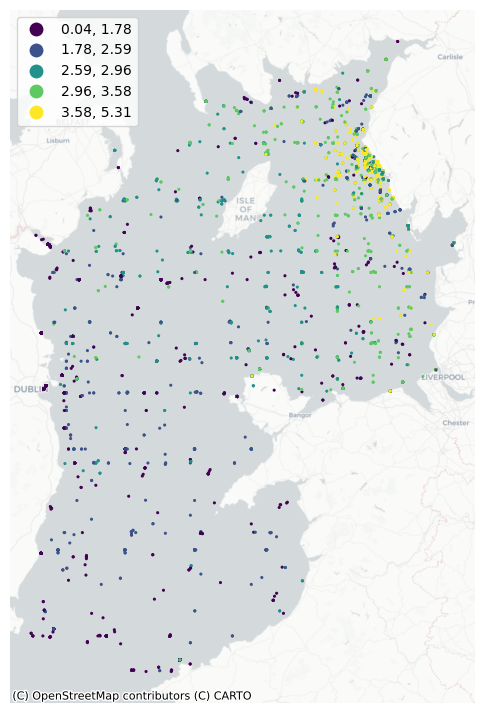

In [ ]:
area_name = "Irish Sea and St. George's Channel"
quick_plot(db[db.area_name==area_name], column='activity_log', alpha=1, ms=5)

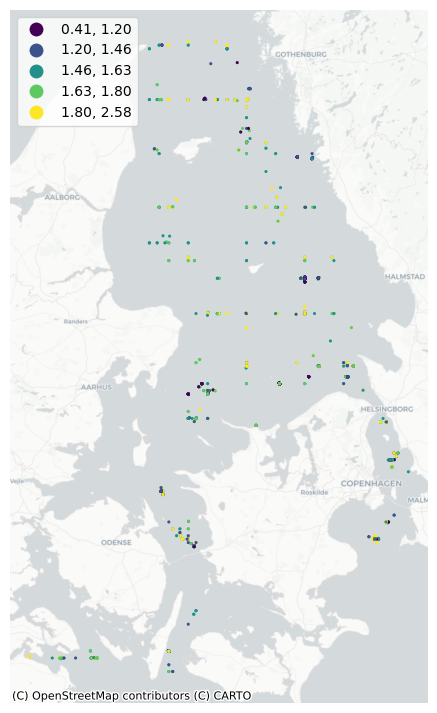

In [ ]:
area_name = "Kattegat"
quick_plot(db[db.area_name==area_name], column='activity_log', alpha=1, ms=5)

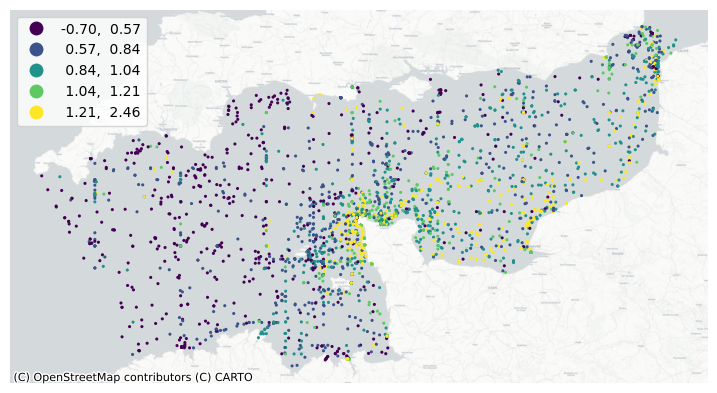

In [ ]:
area_name = "English Channel"
quick_plot(db[db.area_name==area_name], column='activity_log', alpha=1, ms=5)

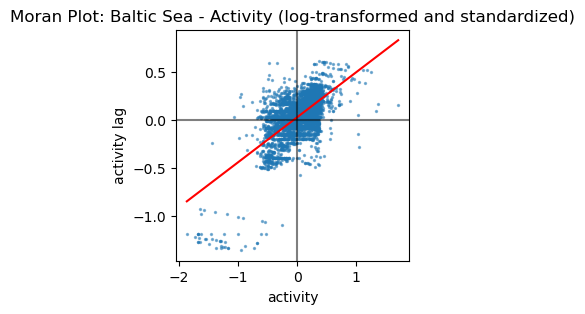

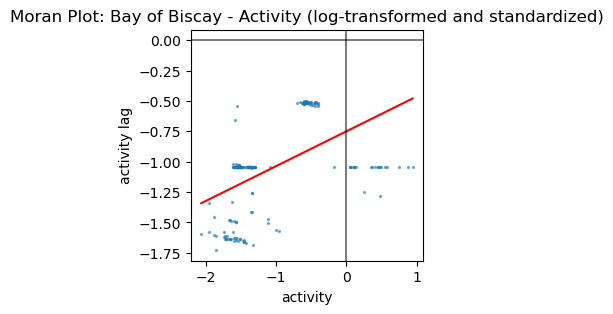

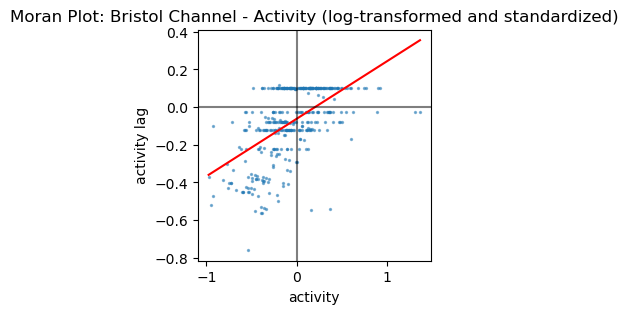

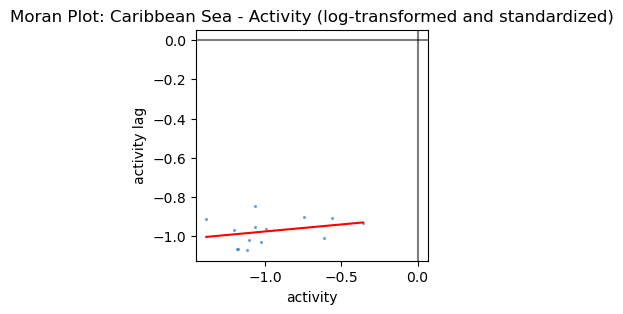

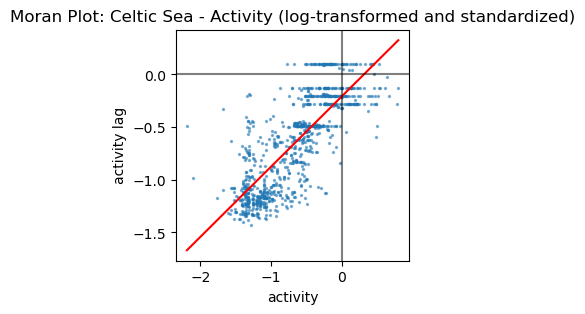

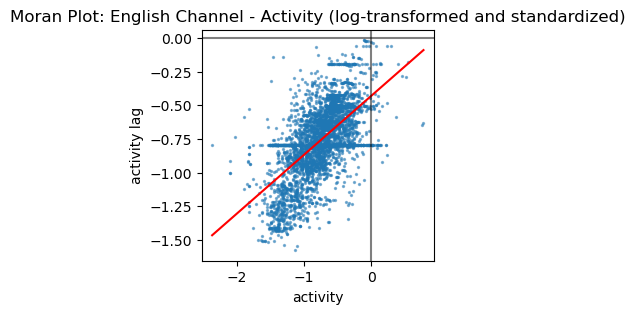

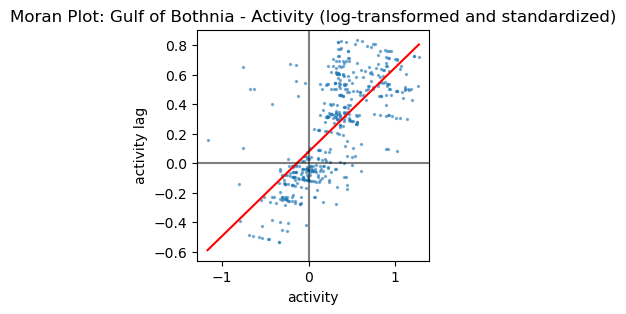

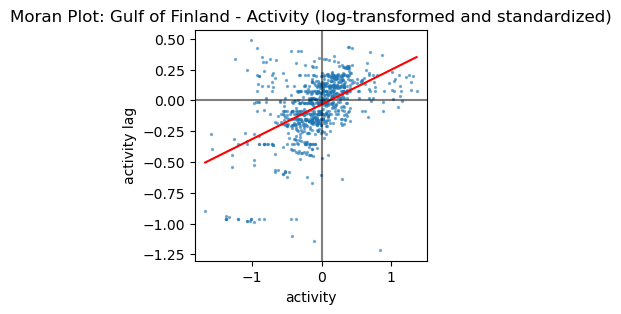

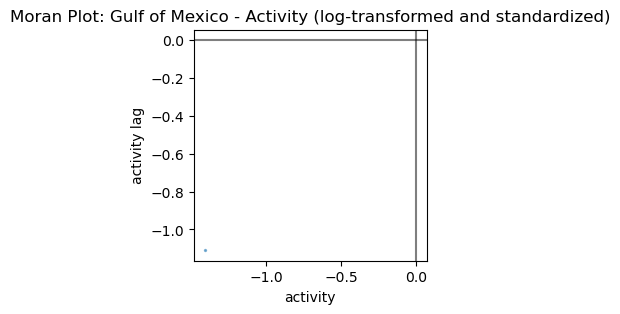

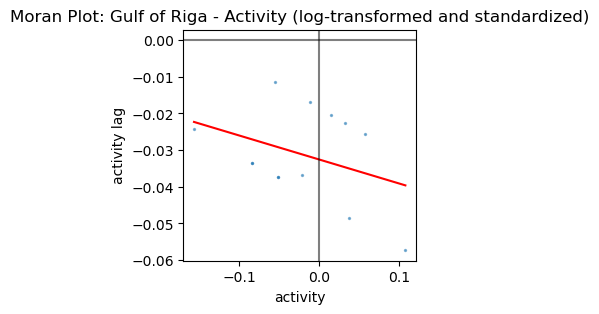

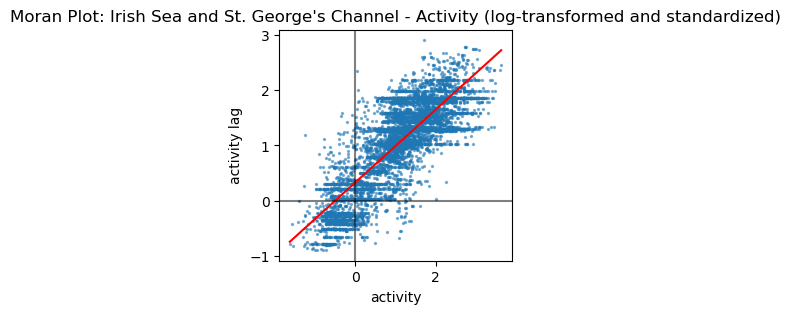

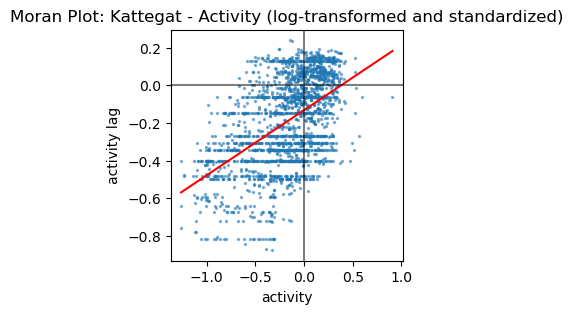

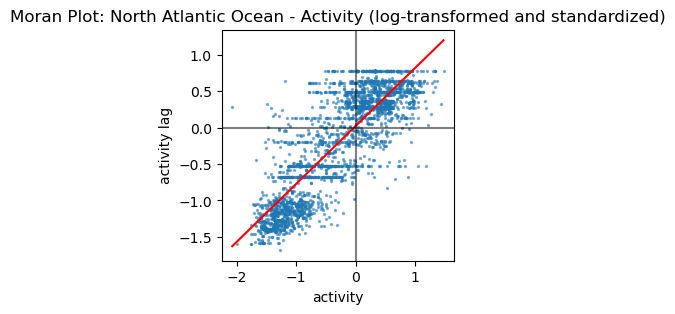

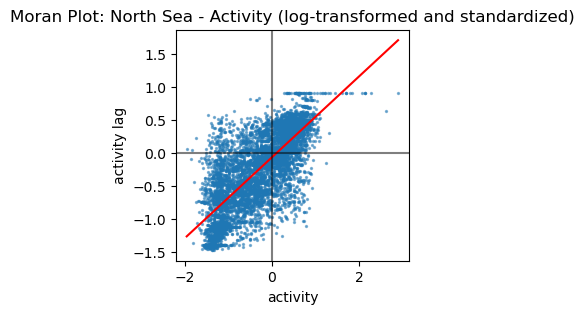

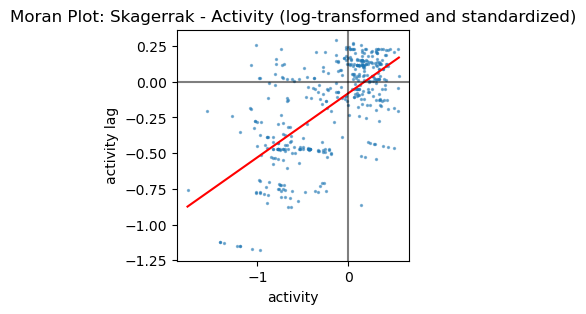

In [ ]:
for name, df in db.groupby('area_name'):
    f, ax = plt.subplots(1, figsize=(3, 3))
    seaborn.regplot(
        x="activity_std",
        y="activity_lag_std",
        ci=None,
        data=df,
        line_kws={"color": "r", "lw":1.5},
        scatter_kws={"alpha": 0.5, "s": 2}
    )
    ax.axvline(0, c="k", alpha=0.5)
    ax.axhline(0, c="k", alpha=0.5)
    ax.set_xlabel("activity")
    ax.set_ylabel("activity lag")
    ax.set_title(f"Moran Plot: {name} - Activity (log-transformed and standardized)")

## Local spatial autocorrelation

Moran’s 
 does not indicate areas within the map where specific types of values (e.g., high, low) are clustered, or instances of explicit dispersion. In other words, Moran’s I can tell us whether values in our map cluster together (or disperse) overall, but it will not inform us about where specific clusters (or outliers) are.

In [ ]:
lisa = esda.moran.Moran_Local(db["activity_log"], w)

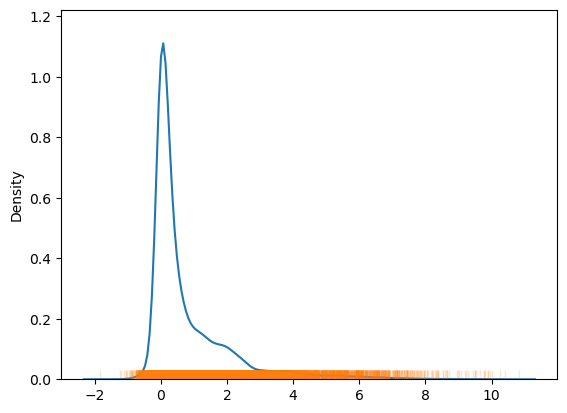

In [ ]:
ax = seaborn.kdeplot(lisa.Is)
seaborn.rugplot(lisa.Is, ax=ax, alpha=0.2);

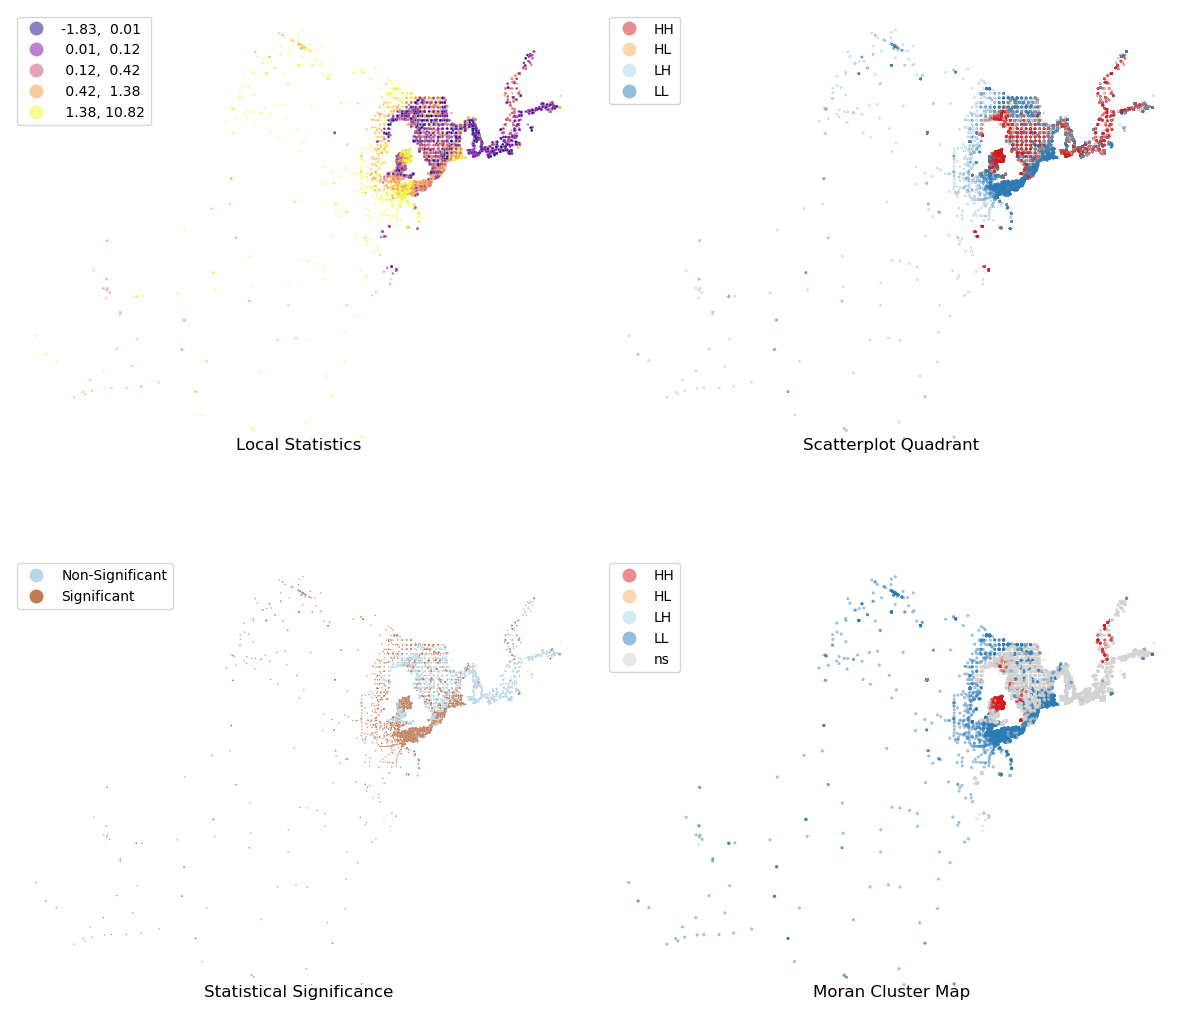

In [ ]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
db.assign(
    Is=lisa.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.5,
    legend=True,
    markersize=3,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quadrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, db, p=1, ax=ax, markersize=0.1, alpha=0.5)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pd.Series(
    1 * (lisa.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=db.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
db.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    alpha=0.8,
    markersize=1,
    ax=ax,
)

# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quadrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, db, p=0.05, ax=ax, markersize=0.5, alpha=0.5)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimize in-between white space
f.tight_layout()

## Point pattern analysis

In [ ]:
db['longitude'] = db.get_coordinates().x
db['latitude'] = db.get_coordinates().y

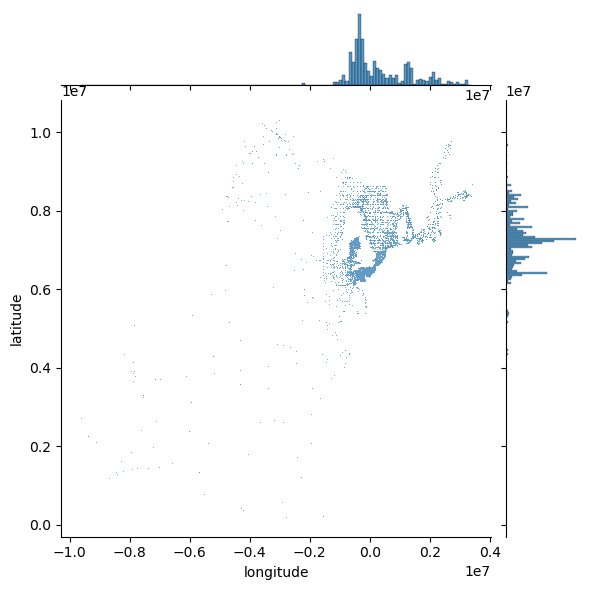

In [ ]:
seaborn.jointplot(x="longitude", y="latitude", data=db, s=0.5);

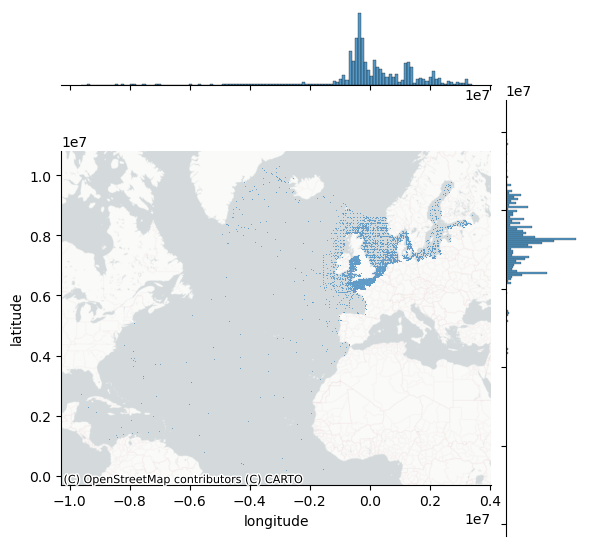

In [ ]:
# Generate scatter plot
joint_axes = seaborn.jointplot(
    x="longitude", y="latitude", data=db, s=0.5
)
contextily.add_basemap(
    joint_axes.ax_joint,
    crs=db.crs,
    source=contextily.providers.CartoDB.PositronNoLabels,
);

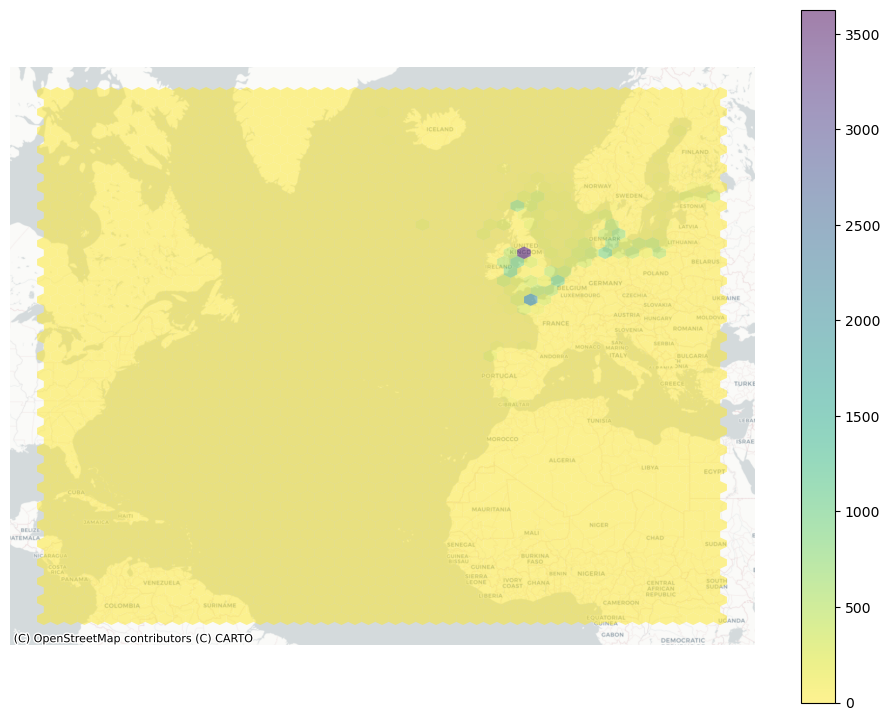

In [ ]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12, 9))
# Generate and add hexbin with 50 hexagons in each
# dimension, no borderlines, half transparency,
# and the reverse viridis colormap
hb = ax.hexbin(
    db["longitude"],
    db["latitude"],
    gridsize=50,
    linewidths=0,
    alpha=0.5,
    cmap="viridis_r",
)
# Add basemap
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)
# Add colorbar
plt.colorbar(hb)
# Remove axes
ax.set_axis_off()

/var/folders/9w/q9wj71814bd5m3n9gpmxn1rm0000gn/T/ipykernel_83617/3087949640.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  seaborn.kdeplot(


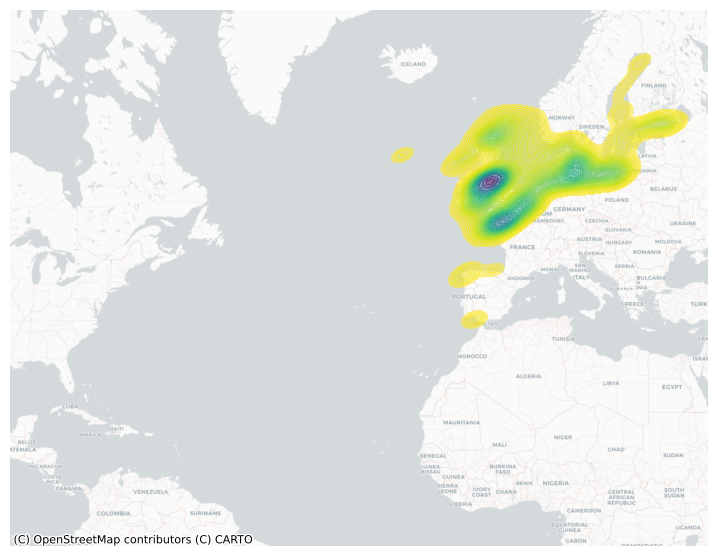

In [ ]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Generate and add KDE with a shading of 50 gradients
# coloured contours, 75% of transparency,
# and the reverse viridis colormap
seaborn.kdeplot(
    x="longitude",
    y="latitude",
    data=db,
    n_levels=50,
    shade=True,
    alpha=0.55,
    cmap="viridis_r",
)
# Add basemap
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)
# Remove axes
ax.set_axis_off()